## 0. Подготовительная часть ##

In [61]:
import numpy as np
import random
import itertools

import gym
import matplotlib.pyplot as plt
from tqdm import tqdm

In [15]:
env = gym.make('Blackjack-v1', natural=True, sab=False, render_mode="rgb_array")

In [47]:
N_ITERS = 100000

## 1. Часть первая с блекджеком и стратегиями ##

In [20]:
def calc_reward(env, n_iters):
    rewards = []
    n_steps = []
    for iterno in tqdm(range(n_iters)):
        obs, _ = env.reset()
        is_finished = False
        current_points, delaers_points, is_usable_ace = obs
        current_step = 0
        current_reward = 0
        while not is_finished:
            to_hit = False
            if current_points < 19:
                to_hit = True
            obs, reward, is_finished, info, _ = env.step(to_hit)
            current_reward += reward
            current_step += 1
            
        rewards.append(current_reward)
        n_steps.append(current_step)
        
        rewards.append(current_reward)
    return (rewards, n_steps)
            

In [48]:
easiest_player = calc_reward(env, N_ITERS)
avg_reward = np.mean(easiest_player[0])
avg_steps = np.mean(easiest_player[1])
print (f"For easiest player (Stand if 19-21 else Hit) average reward is {avg_reward} in {avg_steps} steps")

100%|██████████| 100000/100000 [00:07<00:00, 13411.26it/s]


For easiest player (Stand if 19-21 else Hit) average reward is -0.6495 in 1.81198 steps


In [154]:
def calc_reward_with_strategy(env, n_iters, strategy):
    rewards = []
    n_steps = []
    for iterno in tqdm(range(n_iters)):
        obs = env.reset()
        is_finished = False
        current_points, delaers_points, is_usable_ace = obs
        current_step = 0
        current_reward = 0
        while not is_finished:
            to_hit = strategy[obs]
            obs, reward, is_finished, info = env.step(to_hit)
            current_reward += reward
            current_step += 1
            
        rewards.append(current_reward)
        n_steps.append(current_step)
        
        rewards.append(current_reward)
    return (rewards, n_steps)            

In [107]:
def make_action(Q, state, action_list, eps):
    action = random.choice(action_list)
    if random.random() > eps:
        strategy = dict(zip(Q.keys(), np.argmax(list(Q.values()), axis=1)))
        action = strategy[state]
        
    return action  

In [152]:
def Q_learning(env, action_list, Q, n_iters, alpha, eps, gamma):
    for iterno in tqdm(range(n_iters)):
        obs = env.reset()
        is_finished = False
        while not is_finished:
            action = make_action(Q, obs, action_list, eps)
            new_obs, reward, is_finished, info = env.step(action)
            Q[obs][action] = Q[obs][action] + alpha * (reward + gamma * max(Q[new_obs]) - Q[obs][action])
            obs = new_obs  
    return Q

In [109]:
action_list = (False, True)
possible_points = list(range(4, 32))
possible_cards = list(range(1, 12))

obs_space = list(itertools.product(possible_points, possible_cards, action_list))

In [134]:
alpha = 0.01
eps = 0.1
gamma = 0.5

In [135]:
Q = dict(zip(obs_space, np.zeros((len(obs_space), len(action_list)))))

In [136]:
Q = Q_learning(env, action_list, Q, N_ITERS, alpha, eps, gamma)
strategy = dict(zip(obs_space, np.argmax(list(Q.values()), axis=1)))
rl_player = calc_reward_with_strategy(env, N_ITERS, strategy)

avg_reward = np.mean(rl_player[0])
avg_steps = np.mean(rl_player[1])
print (f"For RL player average reward is {avg_reward} in {avg_steps} steps")

100%|██████████| 100000/100000 [00:07<00:00, 13243.75it/s]

For RL player average reward is -0.053965 in 1.65127 steps


In [227]:
def reward_while_learning(env, action_list, Q, n_iters, alpha, eps, gamma, step):
    rewards = []
    for iterno in range(n_iters):
        obs = env.reset()
        is_finished = False
        while not is_finished:
            action = make_action(Q, obs, action_list, eps)
            new_obs, reward, is_finished, info = env.step(action)
            Q[obs][action] = Q[obs][action] + alpha * (reward + gamma * max(Q[new_obs]) - Q[obs][action])
            obs = new_obs
        if iterno % step == 0:
            strategy = dict(zip(obs_space, np.argmax(list(Q.values()), axis=1)))
            current_player = calc_reward_with_strategy2(env, N_ITERS, strategy)
            rewards.append(np.mean(current_player[0]))    
    return rewards

In [142]:
step = 500
Q = dict(zip(obs_space, np.zeros((len(obs_space), len(action_list)))))
mean_rewards = reward_while_learning(env, action_list, Q, N_ITERS, alpha, eps, gamma, step)

In [143]:
def plot_rewards(mean_rewards, n_iters, step):
    plt.figure(figsize=(10, 7))
    indicies = np.arange(0, n_iters, step)
    plt.plot(indicies, mean_rewards, linewidth=1.5)
    plt.xlabel("Episodes played")
    plt.ylabel("Average reward")
    plt.title("Average reward during training")
    plt.xlim(left=0)
    plt.xlim(right=n_iters)
    plt.minorticks_on()
    plt.grid(True)

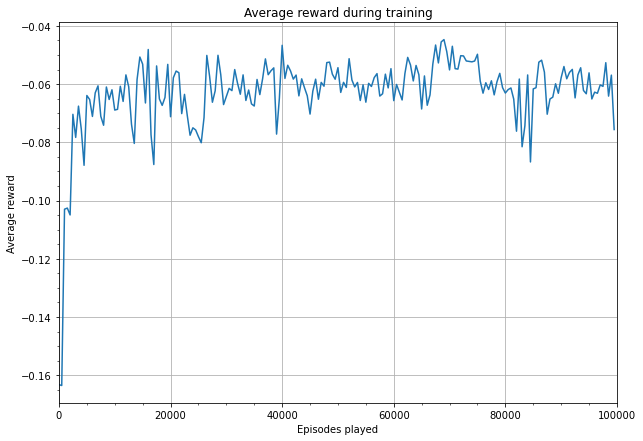

In [145]:
plot_rewards(mean_rewards, N_ITERS, step)

Как видно, стратегия проигрышная, и рано или поздно, казино выиграет все, если банк игрока конечный

## 2. Часть вторая, удвоенная ##

In [146]:
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackDoubleEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 0:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 1:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        else: # double: add a card to players hand, end the game, double reward
            self.player.append(draw_card(self.np_random))
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer)) * 2
             
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [147]:
env = BlackjackDoubleEnv()
env.natural = True

action_list = (0, 1, 2)
Q = dict(zip(obs_space, np.zeros((len(obs_space), len(action_list)))))

In [208]:
alpha = 0.05
eps = 0.1
gamma = 0.1

In [209]:
Q = Q_learning(env, action_list, Q, N_ITERS, alpha, eps, gamma)
strategy = dict(zip(obs_space, np.argmax(list(Q.values()), axis=1)))
rl_can_double_player = calc_reward_with_strategy(env, N_ITERS, strategy)

avg_reward = np.mean(rl_can_double_player[0])
avg_steps = np.mean(rl_can_double_player[1])
print (f"For RL player with doubling average reward is {avg_reward} in {avg_steps} steps")

100%|██████████| 100000/100000 [00:06<00:00, 15278.86it/s]

For RL player with doubling average reward is -0.032765 in 1.57031 steps


In [211]:
step = 1000
Q = dict(zip(obs_space, np.zeros((len(obs_space), len(action_list)))))
mean_rewards = reward_while_learning(env, action_list, Q, N_ITERS, alpha, eps, gamma, step)

100%|██████████| 100000/100000 [00:09<00:00, 10787.80it/s]


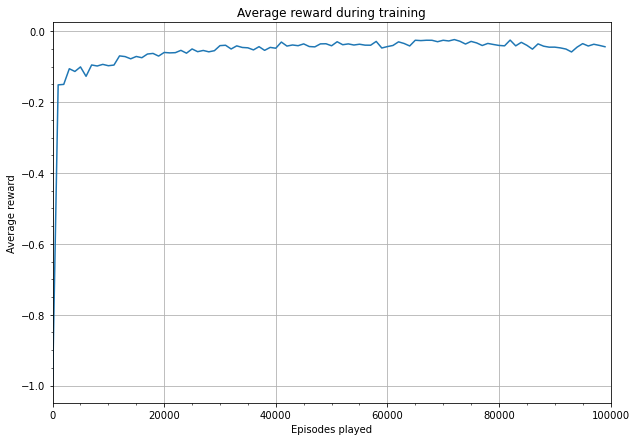

In [213]:
plot_rewards(mean_rewards, N_ITERS, step)

## 3. Часть третья, в главной роли — Дастин Хоффман ##

In [221]:
def calc_reward_with_strategy2(env, n_iters, strategy):
    rewards = []
    n_steps = []
    for iterno in tqdm(range(n_iters)):
        obs = env.reset()
        is_finished = False
        #current_points, delaers_points = obs
        current_step = 0
        current_reward = 0
        while not is_finished:
            to_hit = strategy[obs]
            obs, reward, is_finished, info = env.step(to_hit)
            current_reward += reward
            current_step += 1
            
        rewards.append(current_reward)
        n_steps.append(current_step)
        
        rewards.append(current_reward)
    return (rewards, n_steps) 

In [214]:
class BlackjackDoubleCardsCountEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(         # пересчитать пространство для подсчета               
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2), spaces.Discrete(100))
        )
        self.seed()
        self.standart_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.deck = self.standart_deck * 4
        self.cards_count = 0
        self.mathing = {
            1: -1,
            2: 0.5,
            3: 0.5,
            4: 1,
            5: 1.5,
            6: 1,
            7: 0.5,
            8: 0,
            9: -0.5,
            10: -1,
        }

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab
    
    def draw_card(self, np_random):
        card = int(np_random.choice(self.deck))
        # убрать карту из колоды при раздаче
        self.deck.remove(card)
#         print(self.deck)
        return card

    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]
    
    def count(self, card):
        self.cards_count += self.mathing[card] 

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 0:  # hit: add a card to players hand and return
            card = self.draw_card(self.np_random)
            self.count(card)
            self.player.append(card)
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 1:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
            for card in self.dealer[1:]:
                self.count(card)      
        else: # double: add a card to players hand, end the game, double reward
            card = self.draw_card(self.np_random)
            self.count(card)
            self.player.append(card)
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            for card in self.dealer[1:]:
                self.count(card)   
            reward = cmp(score(self.player), score(self.dealer)) * 2
             
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.cards_count)

    def reset(self):
        if len(self.deck) < 15:
            self.deck = self.standart_deck * 4
            self.cards_count = 0
        cards = self.draw_hand(self.np_random)
        self.dealer = cards
        for card in cards:
            self.count(card)  
        cards = self.draw_hand(self.np_random)
        self.player = cards
        for card in cards:
            self.count(card)  
#         print(self.deck)
        return self._get_obs()

In [215]:
env = BlackjackDoubleCardsCountEnv()
env.natural = True

action_list = (0, 1, 2)
max_count = 4 * (1 * 1.5 + 3 * 0.5 + 2 * 1)
min_count = 4 * (4 * (-1) - 0.5 - 1)
obs_space = list(itertools.product(range(4, 32), range(1, 12), (True, False), np.arange(min_count, max_count, 0.5)))
Q = dict(zip(obs_space, np.zeros((len(obs_space), len(action_list)))))

In [223]:
alpha = 0.01
eps = 0.1
gamma = 0.5

In [224]:
Q = Q_learning(env, action_list, Q, N_ITERS, alpha, eps, gamma)
strategy = dict(zip(obs_space, np.argmax(list(Q.values()), axis=1)))
rl_can_count_player = calc_reward_with_strategy2(env, N_ITERS, strategy)

avg_reward = np.mean(rl_can_count_player[0])
avg_steps = np.mean(rl_can_count_player[1])
print (f"For RL player with counting average reward is {avg_reward} in {avg_steps} steps")

100%|██████████| 100000/100000 [00:07<00:00, 13732.87it/s]

For RL player with counting average reward is -0.077695 in 1.45548 steps


In [228]:
step = 1000
Q = dict(zip(obs_space, np.zeros((len(obs_space), len(action_list)))))
mean_rewards = reward_while_learning(env, action_list, Q, N_ITERS, alpha, eps, gamma, step)

100%|██████████| 100000/100000 [00:06<00:00, 14668.66it/s]


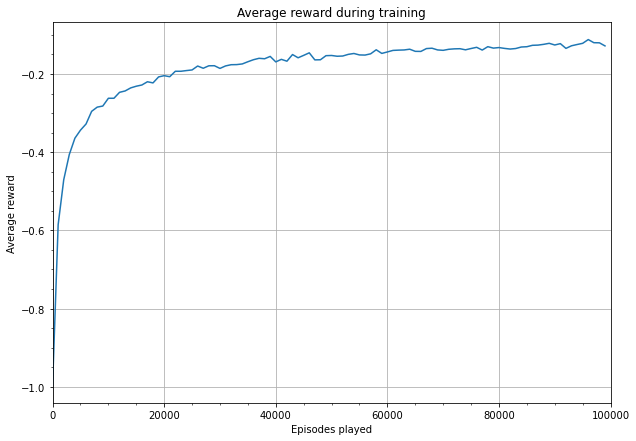

In [230]:
plot_rewards(mean_rewards, N_ITERS, step)

## 5. Выводы ##

Каждые улучшение стратегии игры приводит к чуть более хорошему результату, но при этом этого все равно не хватет, чтобы обыграть казино